In this EDA notebook, we are going to answer the following questions. 

* 1) What percentage of all transactions are credit card frauds?
* 2) What is the average amount of fraud happening?
* 3) Which type of cards are most affected? (Credit, Debit or Charge Card)
* 4) Which company issued credit cards are affected the most? (Visa, Master, Discover, any other)
* 5) During what time of the day, the frauds are happening the most? Or they are randomly distributed?
* 6) What device type are fraudsters using to commit fraud? (Laptop, Mobile or some other means)
* 7) If mobile, what type of mobile device are fraudsters using? (Android, iOS or any other)
* 8) Which browsers are being used the most by fraudsters? 
* 9) Which email domains are being used the most for fraudulent activities?
* 10) Which product is heavily subjected to fraud?
 
Lets work on each one of the above questions
* 1) What percentage of all transactions are credit card frauds?

In [12]:
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from db.mysql import Engine

db_conn = Engine.get_db_conn()
# train = pd.read_sql('train_cleaned', db_conn)
train = pd.read_csv('train_cleaned.csv')

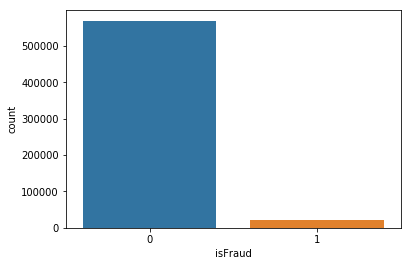

Fraud transactions percentage is 
 0    0.96501
1    0.03499
Name: isFraud, dtype: float64


In [13]:
sns.countplot(x='isFraud', data=train)
plt.show()
fraud_percent = train['isFraud'].value_counts(normalize=True)
print('Fraud transactions percentage is \n', fraud_percent)

* 2) What is the average amount of fraud happening?

                       isFraud
amount_buckets                
(0.25, 25.95]         0.055889
(25.95, 35.95]        0.032052
(35.95, 49.0]         0.032250
(49.0, 57.95]         0.019431
(57.95, 68.769]       0.028513
(68.769, 100.0]       0.036170
(100.0, 117.0]        0.019742
(117.0, 159.95]       0.043026
(159.95, 275.293]     0.038037
(275.293, 31937.391]  0.050870
Transaction Amounts Quantiles:
0.10      25.950
0.25      43.321
0.50      68.769
0.75     125.000
0.95     445.000
0.99    1104.000
Name: TransactionAmt, dtype: float64


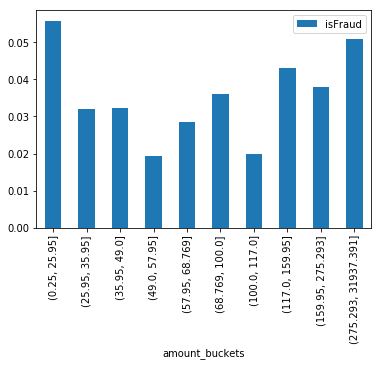

In [14]:
# Convert continuous variable into 20 discrete equal sized buckets by using qcut 
train['amount_buckets'] = pd.qcut(train['TransactionAmt'], 10)
df = train.groupby('amount_buckets')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False)
print(df)
df.plot.bar()

train['TransactionAmt'] = train['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(train['TransactionAmt'].quantile([.1, .25, .5, .75, .95, .99]))

As we can see, the mean fraud amount is around 68 dollars. 
* 3) Which type of cards are most affected? (Credit, Debit or Charge Card)

Value counts of card types used for transactions
 debit              0.746963
credit             0.252961
debit or credit    0.000051
charge card        0.000025
Name: card6, dtype: float64
Value counts of card types affected by fraud
 debit     0.517552
credit    0.482448
Name: card6, dtype: float64
card6
charge card         59.528133
credit             190.034359
debit              116.332757
debit or credit    104.065667
Name: TransactionAmt, dtype: float64


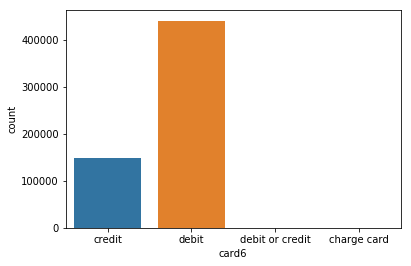

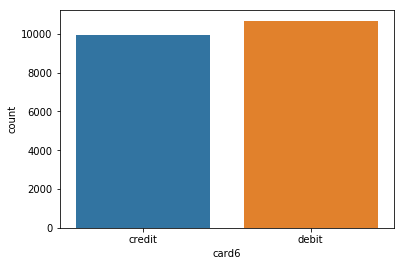

In [15]:
# Card6 label shows the type of the debit card. Lets plot the value_counts and see, which type 
# are most affected.
train_fraud = train[train.isFraud.values==1]

card6_val_counts = train['card6'].value_counts(normalize=True)
print('Value counts of card types used for transactions\n', card6_val_counts)

card6_fraud_val_counts = train_fraud['card6'].value_counts(normalize=True)
print('Value counts of card types affected by fraud\n', card6_fraud_val_counts)

# Lets also check the usage of card type
sns.countplot(x='card6', data=train)
plt.show()
# So Debit cards are mostly used to make transactions. 

sns.countplot(x='card6', data=train_fraud)
plt.show()
# So credit cards are mostly affected by fraud with 56%

# Average spending on each card type
print(train.groupby('card6')['TransactionAmt'].mean())

Even though, debit cards are mostly used to make online transactions, 
credit cards are also getting closely exploited.

* 4) Which company issued credit cards are affected the most? (Visa, Master, Discover, any other)


Value counts of card issuer used for transactions
 visa                0.653296
mastercard          0.321271
american express    0.014140
discover            0.011293
Name: card4, dtype: float64
Value counts of card issuer affected by fraud
 visa                0.648482
mastercard          0.315003
discover            0.024925
american express    0.011590
Name: card4, dtype: float64
card4
american express    173.057137
discover            265.750425
mastercard          132.387731
visa                133.161806
Name: TransactionAmt, dtype: float64


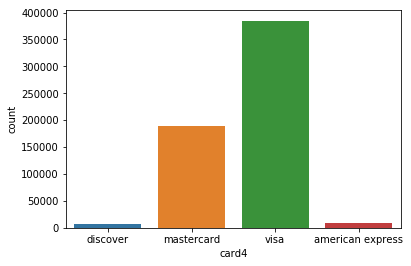

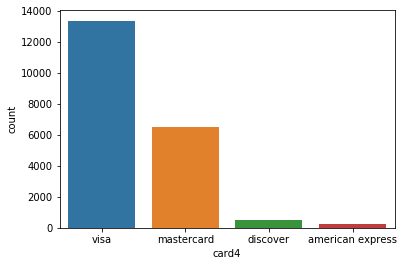

In [16]:
# Card4 label shows the type of the debit card. Lets plot the value_counts and see, which type 
# are most affected.

card4_val_counts = train['card4'].value_counts(normalize=True)
print('Value counts of card issuer used for transactions\n', card4_val_counts)

card4_fraud_val_counts = train_fraud['card4'].value_counts(normalize=True)
print('Value counts of card issuer affected by fraud\n', card4_fraud_val_counts)

# Lets also check the usage of card type
sns.countplot(x='card4', data=train)
plt.show()
# So Debit cards are mostly used to make transactions. 

sns.countplot(x='card4', data=train_fraud)
plt.show()
# So credit cards are mostly affected by fraud with 53%

# Average spending on each card type
print(train.groupby('card4')['TransactionAmt'].mean())

Visa cards are the most used for making transactions. Also they are the one
heavily misused for fraud. Visa was followed by master.

* 5) During what time of the day, the frauds are happening the most? Or they are randomly distributed?

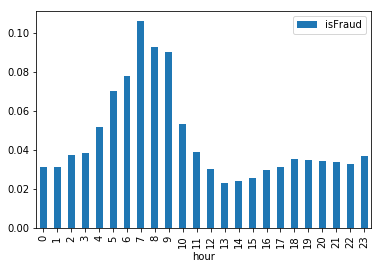

In [17]:
# TransactionDT is the label which has the relative time in seconds from the first transaction 
# Assuming the starting date as 2019-10-30 and time as 00:00 as the first record has 86400 seconds which is 1 day
# Max value in the col 15811131, which would correspond to day 183. So the data spanned over 6 months.
start_date = datetime.datetime.strptime('2019-10-30', "%Y-%m-%d")
train['Date'] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta(seconds=x)))
train['hour'] = train['Date'].dt.hour

# As we only the start time of the first transaction but not the day, we cannot deduce on which days and
# months, more transactions are happening
train.groupby('hour')['isFraud'].mean().to_frame().plot.bar()

plt.show()

Most fraud transactions are happening at 8AM followed by 11AM. And the least number of
transactions happening at 1PM

* 6) What device type are fraudsters using to commit fraud? (Laptop, Mobile or some other means)

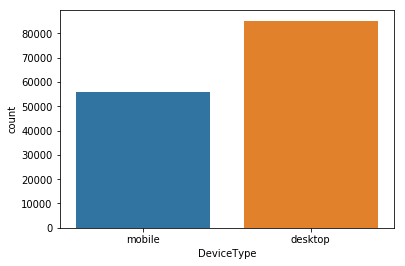

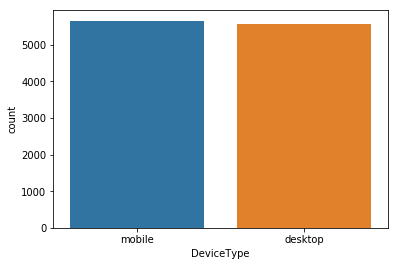

In [18]:
# Check which devices are used to make transactions. 
sns.countplot(x='DeviceType', data=train)
plt.show()

# Check which devices are used to make fraud transactions.
sns.countplot(x='DeviceType', data=train_fraud)
plt.show()

So Desktop is mostly used to make transactions, but mobile is used to commit fraud

*  7) If mobile, what type of mobile device are fraudsters using? (Android, iOS or any other)

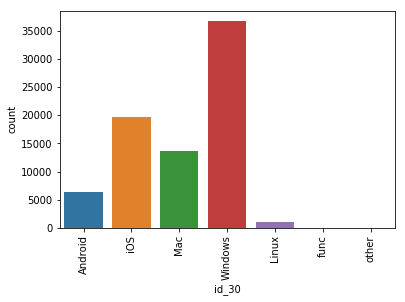

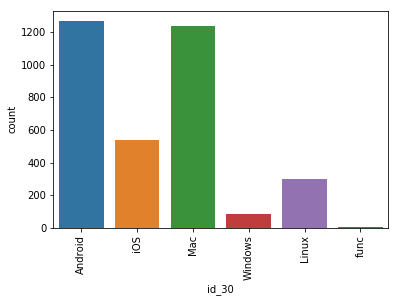

In [19]:
# Split the names of OS to extract the first word.
df_os = pd.DataFrame(train['id_30'].str.split().str.get(0), columns=['id_30'])
df_os_fraud = pd.DataFrame(train_fraud['id_30'].str.split().str.get(0), columns=['id_30'])

# Check which Operating Systems are used to make transactions. 
device_os_plots = sns.countplot(x='id_30', data=df_os)
device_os_plots.set_xticklabels(device_os_plots.get_xticklabels(), rotation=90)
plt.show()

# Check which Operating Systems are used to make fraud transactions.
device_os_fraud_plots = sns.countplot(x='id_30', data=df_os_fraud)
device_os_fraud_plots.set_xticklabels(device_os_plots.get_xticklabels(), rotation=90)
plt.show()

As we can see, most transactions are happening on Windows. However, fraudsters are
committing fraud using Android devices followed by iOS.

*  8) Which browsers are being used the most by fraudsters?

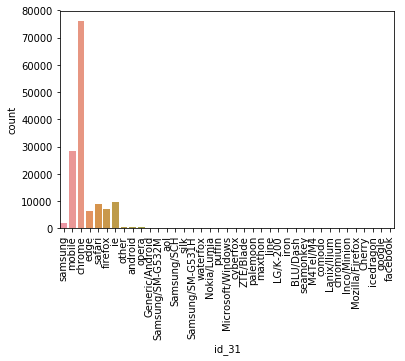

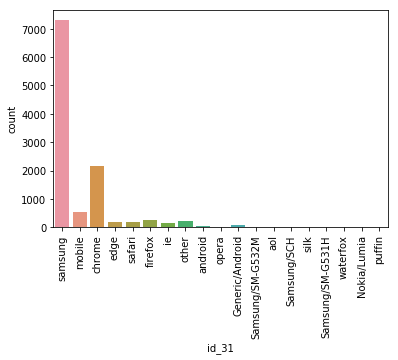

In [23]:
# Split the names of Browsers to extract the first word
df_browser = pd.DataFrame(train['id_31'].str.split().str.get(0), columns=['id_31'])
df_browser_fraud = pd.DataFrame(train_fraud['id_31'].str.split().str.get(0), columns=['id_31'])

# Check which browsers are used to make transactions. 
browser_count_plot = sns.countplot(x='id_31', data=df_browser)
browser_count_plot.set_xticklabels(browser_count_plot.get_xticklabels(), rotation=90)
plt.show()

# Check which browsers are used to make fraud transactions.
browsers_fraud_plot = sns.countplot(x='id_31', data=df_browser_fraud)
browsers_fraud_plot.set_xticklabels(browser_count_plot.get_xticklabels(), rotation=90)

plt.show()

Chrome followed by mobile browser are heavily used for making transactions and fraud

* 9) Which email domains are being used the most for fraudulent activities?

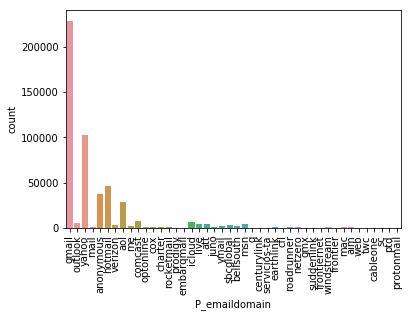

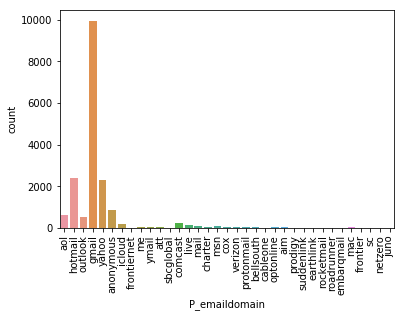

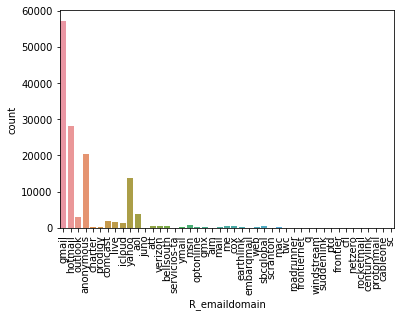

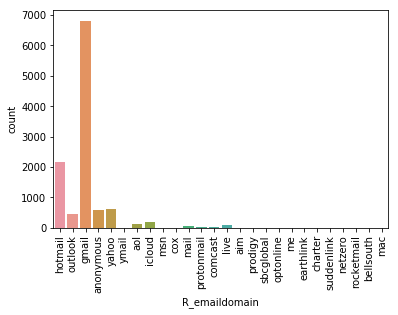

In [21]:
# Split the names of Browsers to extract the first word
df_email_P = pd.DataFrame(train['P_emaildomain'].str.split(".").str.get(0), columns=['P_emaildomain'])
df_email_P_fraud = pd.DataFrame(train_fraud['P_emaildomain'].str.split(".").str.get(0), columns=['P_emaildomain'])

df_email_R = pd.DataFrame(train['R_emaildomain'].str.split(".").str.get(0), columns=['R_emaildomain'])
df_email_R_fraud = pd.DataFrame(train_fraud['R_emaildomain'].str.split(".").str.get(0), columns=['R_emaildomain'])

# Check which email domains are used by purchasers. 
email_count_plot = sns.countplot(x='P_emaildomain', data=df_email_P)
email_count_plot.set_xticklabels(email_count_plot.get_xticklabels(), rotation=90)
plt.show()

# Check which email domains are used by purchasers to commit fraud. 
email_count_plot = sns.countplot(x='P_emaildomain', data=df_email_P_fraud)
email_count_plot.set_xticklabels(email_count_plot.get_xticklabels(), rotation=90)
plt.show()

# Check which email domains of receivers. 
email_count_plot = sns.countplot(x='R_emaildomain', data=df_email_R)
email_count_plot.set_xticklabels(email_count_plot.get_xticklabels(), rotation=90)
plt.show()

# Check which email domains of receivers used to commit fraud. 
email_count_plot = sns.countplot(x='R_emaildomain', data=df_email_R_fraud)
email_count_plot.set_xticklabels(email_count_plot.get_xticklabels(), rotation=90)
plt.show()

gmail.com is the most preferred email, followed by yahoo.com to make transactions
by purchaser and receiver. 
However, gmail.com and hotmail.com are the one which are mostly used for commiting frauds

* 10) Which product is heavily subjected to fraud?

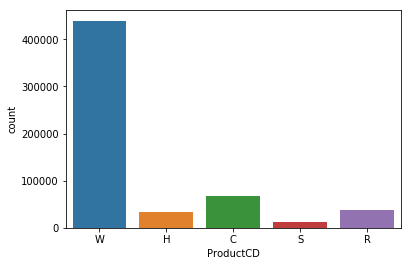

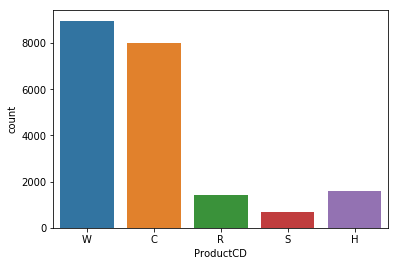

In [22]:
sns.countplot(x="ProductCD", data=train)
plt.show()

sns.countplot(x="ProductCD", data=train_fraud)
plt.show()

Actual product names are masked. However, product W is the one
which is heavily purchased and also subjected to fraud.
However, product C has a fraud percentage of ~10% which is surprising
